In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import autograd.numpy as np
from autograd import grad, elementwise_grad
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt
import pandas as pd

In [6]:
###Utility Functions###
def generate_perturbed_X(X, delta, sampling, S, seed=0):
    np.random.seed(seed=seed)
    N = X.shape[0]
    D = X.shape[1]

    X_expanded = X[np.newaxis, :, :]
    if sampling == 'normal':
         epsilon_s = np.random.normal(0 , delta, size=(S, N, D))
         X_perturbed =  X_expanded + epsilon_s
    else:
        raise  Exception('Sampling {} not defined,'.format('sampling'))

    return X_perturbed

In [7]:
###Utility Functions###
def make_grid(lower, upper, num_points, num_dimensions):
    # Iterate over potential grid sizes
    for grid_size in range(2, num_points+1):
        total_points = grid_size ** num_dimensions
        if total_points >= num_points:
            break

    x = np.linspace(lower, upper, grid_size)
    arrs = np.meshgrid(*([x] * num_dimensions))
    grid = np.concatenate([x.flatten()[..., None] for x in arrs], axis=-1)

    # If the grid has more points than desired, truncate it
    if grid.shape[0] > num_points:
        grid = grid[:num_points]

    return grid

In [8]:
##Utility Functions##
def compute_gradient(fn, X):
  '''
  compute_gradient:
  input: fn, function to explain
       : X(N, D), input dataset
  output: gradient_set(N, D), the gradient of the function
  Note: we suggest you use elementwise_grad function from autograd library
  '''
  f_grad = elementwise_grad(fn)
  gradient_set = f_grad(X)
  return gradient_set

In [24]:

##Inputs and parameters to some of the utility functions are intialized for you.
N = 100
D = 2
sampling = "normal"
S = 1000
delta = 0.5
delta_list = np.linspace(0.000001, 20, 20)
X = make_grid(-5, 5, N, D)
assert X.shape == (N, D)
X_perturbed = generate_perturbed_X(X, delta, sampling, S)
assert X_perturbed.shape == (S, N, D)

In [10]:
###Define the functions you want to explain below, make sure that each function returns (N, ) shape object
def fn_squared(X):
    return np.sum(X ** 2, axis=1)

def fn_cubed(X):
    return np.sum(X ** 3, axis=1)

def fn_exp(X):
    return np.sum(np.exp(X), axis=1)

def fn_sin(X):
    return np.sum(np.sin(X), axis=1)

<h1>Fill the functions below from Homework 1</h1>

In [11]:
def compute_smoothgrad(X_perturbed, fn):
	'''
	compute_smoothgrad: computes smoothgrad explanations
	input: X_perturbed(S, N, D), the perturbed input is computed by another function called generate_X_perturbed()
		 : f, the function to explain
	output: W_sg(N,D), an explanation
	'''
	S = X_perturbed.shape[0]
	N = X_perturbed.shape[1]
	D = X_perturbed.shape[2]

	assert X_perturbed.shape == (S, N, D)

    # grad_f = elementwise_grad(f)
    # gradient = grad_f(X_perturbed)
	grad_f = elementwise_grad(fn)
	gradients = np.zeros((S, N, D))

	for s in range(S):
		gradients[s] = grad_f(X_perturbed[s])

	assert gradients.shape == (S, N, D)
	W_sg = np.mean(gradients, axis=0)
	assert W_sg.shape == (N, D)

	return W_sg

In [12]:

def compute_Lime(X_perturbed, fn):
	'''
	compute_Lime: computes lime explanations
	input: X_perturbed(S, N, D):  the perturbed input computed by generate_perturbed_input function
		 : f - the function to explain
	output: Explanations(N, D)
	'''

	assert len(X_perturbed.shape) == 3
	S = X_perturbed.shape[0]
	N = X_perturbed.shape[1]
	D = X_perturbed.shape[2]

	explanations = np.zeros((N,D))
	reg = LinearRegression()

	for n in range(N):
		x =  X_perturbed[:, n, :]
		y_s = fn(x)
		if len(y_s.shape) == 3:
			y_s = y_s.reshape(-1)
		else:
			y_s = y_s
		reg.fit(x, y_s)
		explanations[n] = reg.coef_

	return explanations

In [13]:
def compute_faithfulness_loss(W_G, W_E):
	'''
	compute_faithfulness_loss : computes the loss for the faithfulness objective
	input : W_G(N, D), the gradient of the function to explain
		  : W_E(N,D), an explantion of the function using a certain explanation method, which could be smoothgrad, lime, our method, etc
	output: summation: A sum of the difference between the W_G and W_E
	'''

	diff_matrix = W_G - W_E
	norm_matrix = np.power(diff_matrix,2)
	summation = np.sum(norm_matrix)
	return summation

In [14]:
def compute_robustness_loss(W_E):
    '''
    compute_robustness_loss: computes the loss for the robustness objective
    input : W_E: the explanation,
    output: the sum of the difference between pair of points n and n_prime (W_E_n and W_E_n_prime)
    '''
    difference = W_E[:, np.newaxis, :] - W_E[np.newaxis, :, :]
    squared_difference = np.sum(difference ** 2, axis=2)
    summation = np.sum(squared_difference)

    return summation

<h1>Question 1: Exploring tradeoffs</h1>
The function for plotting the robustness loss vs faiithfulness loss is provided for you. Plug in the losses and make the plot for each function listed.

In [15]:
def tradeoff_plot(faithfulness_losses_sg,
                  robustness_losses_sg,
                  faithfulness_losses_lime,
                  robustness_losses_lime,
                  delta_list, title):
    '''
    faithfulness_losses_sg: list of faithfulness loss values for a function  explained by  SmoothGrad
    robustness_losses_sg: list of robustness loss values for a function  explained by  SmoothGrad
    faithfulness_losses_lime: list of faithfulness loss values for a function  explained by  Lime
    robustness_losses_lime: list of robustness loss values for a function  explained by  Lime
    delta_list: list of delta values
    title: title of the plot
    '''
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.scatter(robustness_losses_sg,
               faithfulness_losses_sg,
               marker='+',
               s=100,
               color='black',
               label='Smoothgrad')

    ax.scatter(robustness_losses_lime,
              faithfulness_losses_lime,
               marker='x',
               color='red',
               s=100,
               label='Lime')

    plt.xlabel('Robustness Loss')
    plt.ylabel('Faithfulness Loss')
    plt.title('Trade off Plot: ' + title)
    plt.legend()
    plt.show()

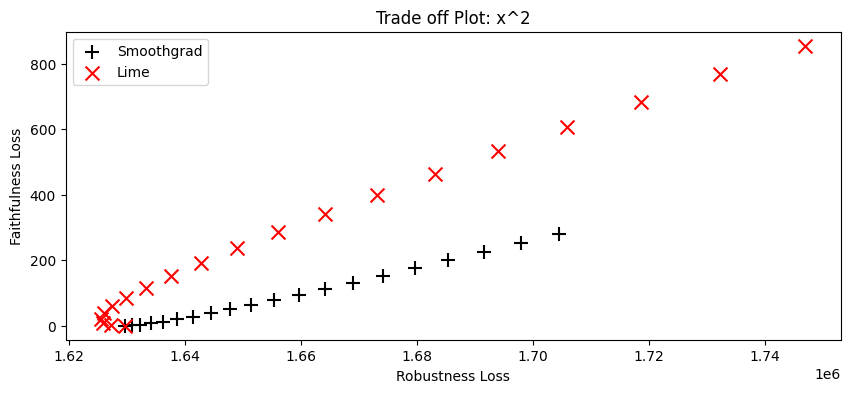

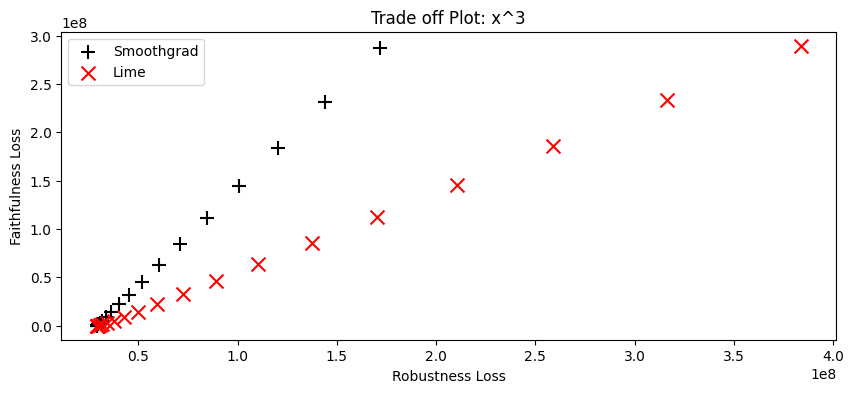

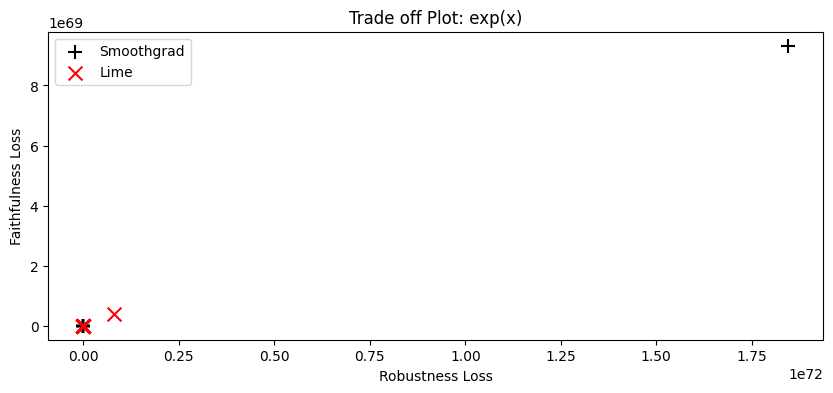

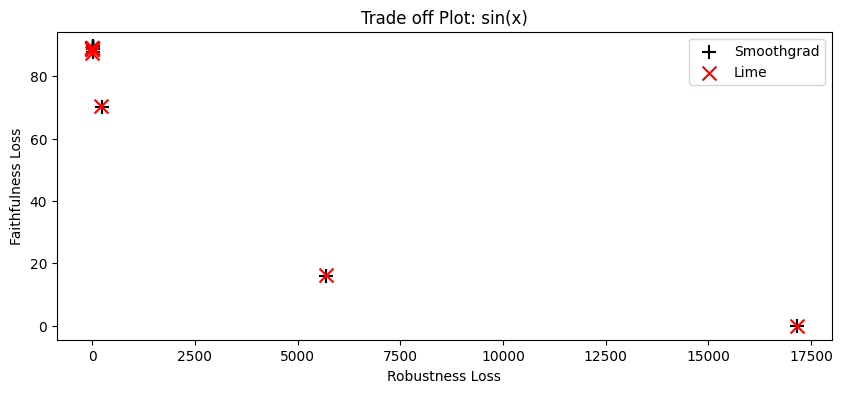

In [25]:
# Helper function for calculating losses
def compute_losses(X, fn, delta_list, S, sampling="normal"):
    smoothgrad_faithfulness = []
    smoothgrad_robustness = []
    lime_faithfulness = []
    lime_robustness = []

    for delta in delta_list:
        X_perturbed = generate_perturbed_X(X, delta, sampling, S)
        gradient_set = compute_gradient(fn, X)

        # SmoothGrad
        smoothgrad_W = compute_smoothgrad(X_perturbed, fn)
        smoothgrad_faithfulness.append(compute_faithfulness_loss(gradient_set, smoothgrad_W))
        smoothgrad_robustness.append(compute_robustness_loss(smoothgrad_W))

        # LIME
        lime_W = compute_Lime(X_perturbed, fn)
        lime_faithfulness.append(compute_faithfulness_loss(gradient_set, lime_W))
        lime_robustness.append(compute_robustness_loss(lime_W))

    return (smoothgrad_faithfulness, smoothgrad_robustness, lime_faithfulness, lime_robustness)

# Functions for graphing
functions = [fn_squared, fn_cubed, fn_exp, fn_sin]
function_names = ["x^2", "x^3", "exp(x)", "sin(x)"]

for fn, title in zip(functions, function_names):
    smoothgrad_faithfulness, smoothgrad_robustness, lime_faithfulness, lime_robustness = compute_losses(X, fn, delta_list, S)
    tradeoff_plot(smoothgrad_faithfulness,
                  smoothgrad_robustness,
                  lime_faithfulness,
                  lime_robustness,
                  delta_list,
                  title)